<a href="https://colab.research.google.com/github/biegunk/Duelling-DQN-for-ma-gym-Switch/blob/main/Duelling_DQN_for_Switch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up and Installation

In [1]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
# !pip install -U gym[atari] > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 1414, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 1414 (delta 239), reused 375 (delta 156), pack-reused 931
Receiving objects: 100% (1414/1414), 4.00 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (702/702), done.
/content/ma-gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 82 not upgraded.


# Imports

In [2]:
%matplotlib inline
import gym
import ma_gym
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
from collections import namedtuple
import time
import warnings
import random

# Helpers

In [3]:
warnings.filterwarnings("ignore")


Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))


def argmax(array):
    """Returns the maximal element, breaking ties randomly."""
    return np.random.choice(np.flatnonzero(array == array.max()))


def is_gpu():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Stores transition in experience buffer."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)

        # overwrite old experience if capacity is reached
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a random sample of experience."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
def train_agents(agents, env, num_eps=1000, test_every=50):
    """Trains the DQN agents to play Switch."""

    start_time = time.time()

    # initialise list to store rewards
    ep_rewards = []
    test_rewards = []

    # ensure agents are exploring
    for agent in agents:
        agent.explore = True

    # iterate over each episode
    for ep in range(num_eps):

        # initialise the environment and state
        ep_reward = 0
        step = 0
        obs = env.reset()
        done_n = [False for _ in range(env.n_agents)]

        # add step count to each agent's observation
        [x.append(step / 50) for x in obs]
        
        # loop until episode termination
        while not all(done_n):

            # get actions
            actions = [agent.get_action(obs[i]) for i, agent in enumerate(agents)]

            # perform actions
            obs_new, rewards, done_n, _ = env.step(actions)

            # update step count
            step += 1

            # append new step count to new observation
            [x.append(step / 50) for x in obs_new]

            # calculate joint reward
            joint_reward = sum(rewards)
            ep_reward += joint_reward

            # each agent takes a step
            for i, agent in enumerate(agents):
                agent.train(obs[i], actions[i], joint_reward, obs_new[i], done_n[i])

            # move to the next state
            obs = obs_new

        # update the target network every target_update episodes
        if ep % target_update == 0:
            for agent in agents:
                agent._update_target_net()
        
        # save reward for this episode
        ep_rewards.append(ep_reward)

        # log results and test agents
        if ep % test_every == 0:
            current_time = time.time()

            print(f'Ep: {ep} / '
                f'(Last {test_every:,.0f}) Mean: {np.mean(ep_rewards[-test_every:]):.1f} / '
                f'Min: {np.min(ep_rewards[-test_every:]):.1f} / '
                f'Max: {np.max(ep_rewards[-test_every:]):.1f} / '
                f'Time/Ep: {ep / (current_time - start_time):.1f}'
                )
            
            test_rewards.append(test_agents(agents, env))
            # ensure agents are exploring after test episode complete
            for agent in agents:
                agent.explore = True

    # perform final log and test at end of training
    current_time = time.time()

    print(f'Ep: {ep} / '
        f'(Last {test_every:,.0f}) Mean: {np.mean(ep_rewards[-test_every:]):.1f} / '
        f'Min: {np.min(ep_rewards[-test_every:]):.1f} / '
        f'Max: {np.max(ep_rewards[-test_every:]):.1f} / '
        f'Time/Ep: {ep / (current_time - start_time):.1f}'
        )
            
    test_rewards.append(test_agents(agents, env))
            
    return ep_rewards, test_rewards


def test_agents(agents, env):
    """Performs a single test episode for the trained agents."""

    # ensure agents are not exploring
    for agent in agents:
        agent.explore = False

    done_n = [False for _ in range(env.n_agents)]
    obs = env.reset()

    ep_reward = 0
    step = 0

    # loop until episode termination
    while not all(done_n):

        # add step count to agent observation
        [x.append(step / 50) for x in obs]

        # get actions
        actions = [agent.get_action(obs[i]) for i, agent in enumerate(agents)]

        # perform actions
        obs, rewards, done_n, _ = env.step(actions)

        # save reward
        ep_reward += sum(rewards)

        # increment step count
        step += 1

    print(f'Test Reward: {ep_reward:.1f}')
    return ep_reward

# DQN

In [12]:
class DuellingDQN(nn.Module):

    def __init__(self):
        super(DuellingDQN, self).__init__()
        self.linear1 = nn.Linear(3, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear_val = nn.Linear(64, 1)
        self.linear_adv = nn.Linear(64, 5)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        val = self.linear_val(x)
        adv = self.linear_adv(x)
        adv_bar = torch.mean(adv, dim=1, keepdim=True)
        Q = val + adv - adv_bar
        return Q


class Agent(object):

    def __init__(self, 
                 batch_size=64, 
                 memory_capacity=1000, 
                 epsilon_start=0.99, 
                 epsilon_end=0.01, 
                 epsilon_decay_horizon=3000, 
                 gamma=0.9, 
                 learning_rate=0.0005,
                 target_update=500):

        self.device = is_gpu()
        self.q_network = DuellingDQN().to(self.device)
        self.q_target = DuellingDQN().to(self.device)
        self.memory = ReplayMemory(memory_capacity)
        self.optimizer = optim.Adam(params=self.q_network.parameters(), lr=learning_rate)

        self.epsilon = epsilon_start
        self.eps_start = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay_horizon = epsilon_decay_horizon

        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.t = 0
        self.explore = True

        # set initial target network parameters to the randomly initialised policty network parameters
        self._update_target_net()

    def get_action(self, obs):
        """Selects action based on agent's policy."""
        if self.explore and np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, 4)
        else:
            with torch.no_grad():
                obs = torch.tensor(obs).to(self.device).unsqueeze(0)
                Q = self.q_network(obs).cpu().detach().numpy()
                return argmax(Q)

    def _update_target_net(self):
        """Hard updates the parameters of the target network with the policy network parameters."""
        self.q_target.load_state_dict(self.q_network.state_dict())

    def _update_epsilon(self):
        """Decays epsilon exponentially while training."""
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-self.t / self.eps_decay_horizon)

    def _save_experience(self, state, action, reward, next_state, done):
        """Pushes transition to memory."""
        state = torch.tensor(state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        next_state = torch.tensor(next_state)

        self.memory.push(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        """Performs a single training step of the agent."""

        self._save_experience(state, action, reward, next_state, done)

        # prevents training if there is not enough memory
        if len(self.memory) < self.batch_size:
            return

        self.t += 1
        self._update_epsilon()

        # sample transitions
        transitions = self.memory.sample(self.batch_size)

        # convert transitions to batch
        batch = Transition(*zip(*transitions))

        # get data from batch
        state_batch = torch.stack(batch.state).to(self.device) # batch_size x 3
        next_state_batch = torch.stack(batch.next_state).to(self.device) # batch_size x 3
        action_batch = torch.cat(batch.action).to(self.device) # batch_size
        reward_batch = torch.cat(batch.reward).to(self.device) # batch_size

        # make mask for non-terminal states
        not_done_batch = 1 - torch.tensor(batch.done, dtype=torch.uint8).to(self.device)

        # calculate Q values of this state
        Q_this = self.q_network(state_batch)

        # get values of only the actions we've taken
        Q_this = Q_this.gather(1, action_batch.unsqueeze(1))

        # calculate max Q of next state
        Q_next = self.q_target(next_state_batch).max(1).values.detach()
    
        # calculate the Q-learning target values
        target = (Q_next * self.gamma * not_done_batch) + reward_batch

        # calculate loss
        loss = F.smooth_l1_loss(Q_this, target.unsqueeze(1))

        # perform a step of optimization of the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-10, 10)
        self.optimizer.step()

        if not self.t % self.target_update:
            self._update_target_net()

# Run Experiments

## Switch2-v0

In [16]:
num_agents = 2
batch_size = 64
target_update = 300
num_eps = 1500
test_every = 50
memory_capacity = int(num_eps / 4)
epsilon_decay_horizon = 3000
gamma = 0.9
v2_agents = [Agent(memory_capacity=memory_capacity, 
                   gamma=gamma, 
                   epsilon_decay_horizon=epsilon_decay_horizon, 
                   batch_size=batch_size, 
                   target_update=target_update) for _ in range(num_agents)]
env = gym.make("Switch2-v0")

v2_ep_rewards, v2_test_rewards = train_agents(v2_agents, env, num_eps, test_every)

Ep: 0 / (Last 50) Mean: -10.0 / Min: -10.0 / Max: -10.0 / Time/Ep: 0.0
Test Reward: -10.0
Ep: 50 / (Last 50) Mean: -9.8 / Min: -10.0 / Max: -1.3 / Time/Ep: 4.8
Test Reward: -10.0
Ep: 100 / (Last 50) Mean: -3.9 / Min: -10.0 / Max: 5.3 / Time/Ep: 4.7
Test Reward: -0.6
Ep: 150 / (Last 50) Mean: -1.0 / Min: -3.8 / Max: -0.6 / Time/Ep: 4.6
Test Reward: -0.6
Ep: 200 / (Last 50) Mean: -0.7 / Min: -1.4 / Max: -0.6 / Time/Ep: 4.6
Test Reward: -0.6
Ep: 250 / (Last 50) Mean: -0.6 / Min: -0.9 / Max: -0.6 / Time/Ep: 4.5
Test Reward: -0.6
Ep: 300 / (Last 50) Mean: -0.7 / Min: -4.6 / Max: -0.6 / Time/Ep: 4.5
Test Reward: -0.6
Ep: 350 / (Last 50) Mean: -0.6 / Min: -0.8 / Max: -0.6 / Time/Ep: 4.5
Test Reward: -0.6
Ep: 400 / (Last 50) Mean: 3.2 / Min: -0.8 / Max: 8.1 / Time/Ep: 4.6
Test Reward: 8.1
Ep: 450 / (Last 50) Mean: 7.3 / Min: -0.6 / Max: 8.1 / Time/Ep: 4.9
Test Reward: 8.1
Ep: 500 / (Last 50) Mean: 7.5 / Min: -0.6 / Max: 8.1 / Time/Ep: 5.3
Test Reward: 8.1
Ep: 550 / (Last 50) Mean: 1.0 / Min: -

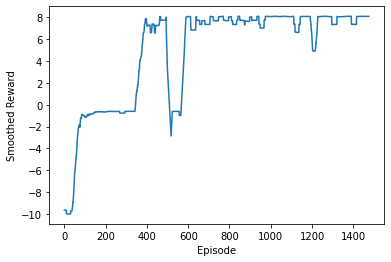

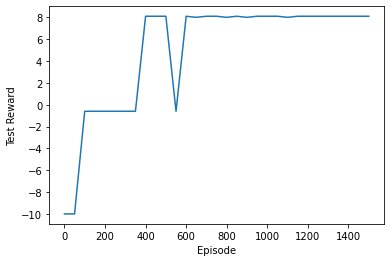

In [17]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

degree = 25

smoothed_rewards = moving_average(v2_ep_rewards, degree)

plt.figure()
plt.plot(np.arange(len(smoothed_rewards)), smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.yticks(np.arange(-10, 9, 2))
plt.show()

plt.figure()
plt.plot(np.arange(len(v2_test_rewards)) * test_every, v2_test_rewards)
plt.xlabel("Episode")
plt.ylabel("Test Reward")
plt.yticks(np.arange(-10, 9, 2))
plt.show()

The model implemented to play Switch2-v0 is a variation of a duelling DQN. This is a deep Q network whose output is a state-value  𝑉  and an advantage function  𝐴 , where  𝑄(𝑠,𝑎)=𝑉(𝑠)+𝐴(𝑠,𝑎)−𝐴¯(𝑠)  where  𝐴¯  is the mean advantage function over all actions from state  𝑠 . The implementation also includes experience replay and a separate target network for calculating the Q-learning targets, updated every 5 episodes.

The experience memory is a cyclical buffer, with a capacity of 500 transitions, that overwrites the least recent memory with new experience once it is full, giving a bias to more recent transitions. At each time-step, the agents each sample a minibatch of experience – here of size 64 – and perform an optimization step of the policy network based on the Huber-loss betweent the predicted Q-values and the Q-learning targets. the use of the Huber-loss helps to stabilise the training process, as it is more robust to outliers than say the mean squared loss. To further stabilise the training process we implement gradient clipping between -10 and +10, and include a low learning rate of 0.0005

The exploration policy of the agents is epsilon-greedy, with an exponentially decaying epsilon from 0.99 to 0.01 over 3000 timesteps. The performance of the agents was very sensitive to the rate of epsilon decay, and we found that the agents did not learn good policies when the epsilon decay was linear or logarithmic. Exponential epsilon decay ensures that the agents explore a lot at low t, but the exploration decays very quickly such that at high t, when the agents have learned an optimal policy, they rarely deviate from these trajectories. However, a final epsilon of 0.01 still ensures some exploration at later times, so that the agents are less likely to converge to a close-to-optimal but still sub-optimal policy.

We were able to achieve a final test score of 8.1 on Switch2-v0 by training the agents on the joint reward at each transition, rather than the individual rewards, and also including the current timestep of the episode in the agents' observations. Optimizing the joint behaviour of the agents coupled with the inclusion of temporal information allows the agents to learn the optimal strategy where one player must wait for the other to cross the tunnel before they can go themselves.

Furthermore, the agents were able to achieve this performance when trained over 1500 episodes with a Q-learning discount factor of 0.9.

## Switch4-v0

In [25]:
num_agents = 4
batch_size = 128
target_update = 300
num_eps = 1500
memory_capacity = int(num_eps / 4)
epsilon_decay_horizon = 4000
gamma = 0.9
v4_agents = [Agent(memory_capacity=memory_capacity, 
                   gamma=gamma, 
                   epsilon_decay_horizon=epsilon_decay_horizon, 
                   batch_size=batch_size, 
                   target_update=target_update) for _ in range(num_agents)]
env = gym.make("Switch4-v0")

v4_ep_rewards, v4_test_rewards = train_agents(v4_agents, env, num_eps, test_every)

Ep: 0 / (Last 50) Mean: -20.0 / Min: -20.0 / Max: -20.0 / Time/Ep: 0.0
Test Reward: -20.0
Ep: 50 / (Last 50) Mean: -14.6 / Min: -20.0 / Max: 2.7 / Time/Ep: 2.0
Test Reward: -20.0
Ep: 100 / (Last 50) Mean: -8.7 / Min: -20.0 / Max: 8.3 / Time/Ep: 1.9
Test Reward: -20.0
Ep: 150 / (Last 50) Mean: -13.9 / Min: -20.0 / Max: 2.2 / Time/Ep: 1.8
Test Reward: -20.0
Ep: 200 / (Last 50) Mean: -13.1 / Min: -20.0 / Max: -2.1 / Time/Ep: 1.8
Test Reward: -7.9
Ep: 250 / (Last 50) Mean: -6.6 / Min: -20.0 / Max: 6.4 / Time/Ep: 1.8
Test Reward: 5.8
Ep: 300 / (Last 50) Mean: -12.2 / Min: -20.0 / Max: 6.4 / Time/Ep: 1.8
Test Reward: -10.6
Ep: 350 / (Last 50) Mean: -4.6 / Min: -20.0 / Max: 6.2 / Time/Ep: 1.8
Test Reward: 6.7
Ep: 400 / (Last 50) Mean: -10.6 / Min: -20.0 / Max: 6.7 / Time/Ep: 1.8
Test Reward: -10.9
Ep: 450 / (Last 50) Mean: -11.1 / Min: -20.0 / Max: -3.5 / Time/Ep: 1.8
Test Reward: -10.6
Ep: 500 / (Last 50) Mean: -15.9 / Min: -20.0 / Max: -5.8 / Time/Ep: 1.8
Test Reward: -20.0
Ep: 550 / (Last 

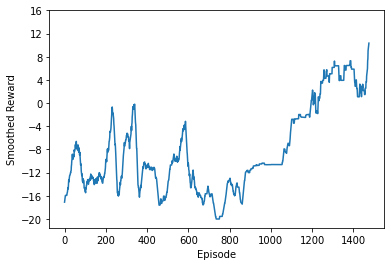

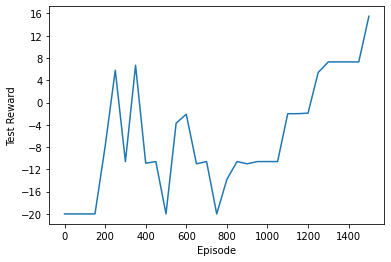

In [28]:
smoothed_rewards = moving_average(v4_ep_rewards, degree)

plt.figure()
plt.plot(np.arange(len(smoothed_rewards)), smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.yticks(np.arange(-20, 17, 4))
plt.show()

plt.figure()
plt.plot(np.arange(len(v4_test_rewards)) * test_every, v4_test_rewards)
plt.xlabel("Episode")
plt.ylabel("Test Reward")
plt.yticks(np.arange(-20, 17, 4))
plt.show()

The main difficulty with transferring the duelling DQN architecture implemented for Switch2-v0 to Switch4-v0 is that with the increased number of players, the sensitivity of the performance to changes in hyperparamters is vastly increased. This is specifically noticeable when varying parameters involved in the exploration, such as intial, final and rate of decay of epsilon. Even moreso than the 2-player version, if epsilon is not decayed at the right speed, the exploration of the agents can completely skew the performance. Specifically, we found the main issue with the 4-player game was the presence of catastrophic forgetting, which was not as much of a problem with only 2 agents. Often the agents would learn the optimal policy, and then later on in the training cycle go back to impeding each other, resulting in very low test scores.

Another issue that is more common in the Switch4-v0 is lazy-agent behaviour. This occurs when the joint policies are stuck in a local optima, as some of the agents are getting to their target, and thus all the agents are experiencing some reward (as we feed the agents the joint reward). If the lazy agents do not explore enough, the little exploration they do can result in impeding the other agents, which makes exploration undesirable. Therefore it is very important to get a balance of enough exploration such that the agents do not become lazy, but also that they do not forget the learned optimal policy.

We found that using an increased experience replay minibatch size of 128 and keeping the epsilon decay horizon the same at 3000 timesteps, we were able to achieve fairly stable results, and the agents scored a final test score of .